In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from radcad import Model, Simulation, Experiment
from radcad.engine import Engine, Backend

sns.set_theme(style="whitegrid")

In [2]:
# EIP4844 configuration
MAX_BLOB_GAS_PER_BLOCK = 786432
TARGET_BLOB_GAS_PER_BLOCK = 393216
MIN_BASE_FEE_PER_BLOB_GAS = 1
BLOB_BASE_FEE_UPDATE_FRACTION = 3338477
GAS_PER_BLOB = 2**17

# simuplation configuration
TIMESTEMPS = 5 * 60 * 24 * 2
RUNS = 1

In [3]:
# EIP-4844 Pricing Formula

def fake_exponential(factor: int, numerator: int, denominator: int) -> int:
    i = 1
    output = 0
    numerator_accum = factor * denominator
    while numerator_accum > 0:
        output += numerator_accum
        numerator_accum = (numerator_accum * numerator) // (denominator * i)
        i += 1
    return output // denominator

def calc_excess_blob_gas(target_blob_gas_per_block: int, parent_excess_blob_gas: int, parent_blob_gas_used: int) -> int:
    if parent_excess_blob_gas + parent_blob_gas_used < target_blob_gas_per_block:
        return 0
    else:
        return parent_excess_blob_gas + parent_blob_gas_used - target_blob_gas_per_block

def get_base_fee_per_blob_gas(min_base_fee_per_blob_gas: int, excess_blob_gas: int, blob_base_fee_update_fraction: int) -> int:
    return fake_exponential(
        min_base_fee_per_blob_gas,
        excess_blob_gas,
        blob_base_fee_update_fraction
    )

In [4]:
# EIP-4844 Blob Fee Market Model

def policy_resource_fee(params, substep, state_history, previous_state):
    target_blob_gas_per_block = params['target_blob_gas_per_block']

    parent_blob_gas_used = previous_state['blob_gas_used']
    parent_excess_blob_gas = previous_state['excess_blob_gas']

    excess_blob_gas = calc_excess_blob_gas(target_blob_gas_per_block, parent_excess_blob_gas, parent_blob_gas_used)

    return {
        'excess_blob_gas': excess_blob_gas
    }

def policy_resource_usage(params, substep, state_history, previous_state):
    process_blob_gas_used = params['process_blob_gas_used']
    
    run = previous_state['run']
    timestep = previous_state['timestep']

    blob_gas_used = process_blob_gas_used(run, timestep)

    return {
        'blob_gas_used': blob_gas_used
    }

def update_excess_blob_gas(params, substep, state_history, previous_state, policy_input):
    excess_blob_gas = policy_input['excess_blob_gas']
    return ('excess_blob_gas', excess_blob_gas)

def update_blob_gas_used(params, substep, state_history, previous_state, policy_input):
    blob_gas_used = policy_input['blob_gas_used']
    return ('blob_gas_used', blob_gas_used)

initial_state = {
    'blob_gas_used': 0,
    'excess_blob_gas': 0,
}

state_update_blocks = [
    {
        'policies': {
            'resource_fee': policy_resource_fee,
        },
        'variables': {
            'excess_blob_gas': update_excess_blob_gas,
        }
    },
    {
        'policies': {
            'resource_usage': policy_resource_usage,
        },
        'variables': {
            'blob_gas_used': update_blob_gas_used,
        }
    },
]

In [5]:
# Demand Sampling

rng = np.random.default_rng()

def truncated_poisson(lam: int, max_value: int, size: int):
    temp_size = size
    while True:
        temp_size *= 2
        temp = rng.poisson(lam=lam, size=temp_size)
        truncated = temp[temp <= max_value]
        if len(truncated) >= size:
            return truncated[:size]
    
def generate_poisson_demand(lam: int):
    return [truncated_poisson(lam=lam, max_value=6, size=TIMESTEMPS + 1) * GAS_PER_BLOB for run in range(RUNS)]

In [6]:
sample = generate_poisson_demand(3)

model = Model(
    initial_state=initial_state,
    state_update_blocks=state_update_blocks,
    params={
        'target_blob_gas_per_block': [TARGET_BLOB_GAS_PER_BLOCK],
        'process_blob_gas_used': [lambda run, timestep: sample[run - 1][timestep]],
    },
)

simulation = Simulation(
    model=model,
    timesteps=TIMESTEMPS,
    runs=RUNS
)

experiment = Experiment(simulations=[simulation])
experiment.engine = Engine(backend=Backend.PATHOS, drop_substeps=True)
result = experiment.run()

In [7]:
df = pd.DataFrame(result)
df

,blob_gas_used,excess_blob_gas,simulation,subset,run,substep,timestep
0,0,0,0,0,1,0,0
1,524288,0,0,0,1,2,1
2,131072,131072,0,0,1,2,2
3,524288,0,0,0,1,2,3
4,131072,131072,0,0,1,2,4
...,...,...,...,...,...,...,...
14396,131072,0,0,0,1,2,14396
14397,262144,0,0,0,1,2,14397
14398,262144,0,0,0,1,2,14398
14399,0,0,0,0,1,2,14399


In [8]:
df["base_fee_per_blob_gas"] = df["excess_blob_gas"].apply(lambda value: get_base_fee_per_blob_gas(MIN_BASE_FEE_PER_BLOB_GAS, value, BLOB_BASE_FEE_UPDATE_FRACTION))

Text(617.2727272727271, 0.5, 'Base Fee Per Blob Gas')

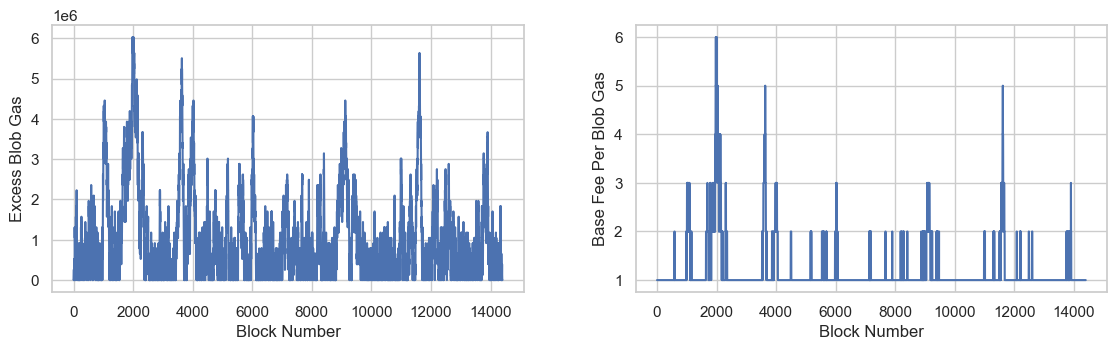

In [10]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
fig.tight_layout(pad=3, w_pad=4, h_pad=3)

ax1.plot(df['timestep'], df['excess_blob_gas'], label='excess_blob_gas')
ax1.set_xlabel('Block Number')
ax1.set_ylabel('Excess Blob Gas')

ax2.plot(df['timestep'], df['base_fee_per_blob_gas'], label='base_fee_per_blob_gas')
ax2.set_xlabel('Block Number')
ax2.set_ylabel('Base Fee Per Blob Gas')